### Many to Many usecase

In [1]:
import nltk
from nltk.corpus import brown

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\dellb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\dellb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [3]:
corpus=brown.tagged_sents(tagset='universal')

In [4]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
len(corpus)

57340

In [6]:
inputs=[]
targets=[]

for sentece_tag_pair in corpus:
    tokens=[]
    target=[]
    for token,tag in sentece_tag_pair:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Bidirectional,LSTM,SimpleRNN,GRU,Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [8]:
train_inputs,test_inputs,train_outputs,test_outputs=train_test_split(inputs,targets,test_size=0.3)

In [9]:
#convert sentences to sequneces

MAX_VOCAB_SIZE=None

#capitalisation might be useful
should_capitalize=False
word_tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE,
                         lower=should_capitalize,
                         oov_token='UNK')
word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int=word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int=word_tokenizer.texts_to_sequences(test_inputs)

In [11]:
#word to integer mapping
word2idx=word_tokenizer.word_index
V=len(word2idx)
print("found %s unique tokens"%V)

found 47517 unique tokens


In [12]:
def flatten(list_of_lists):
    flattened=[val for sublist in list_of_lists for val in sublist]
    return flattened

In [13]:
all_train_targets=set(flatten(train_outputs))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [14]:
all_test_targets=set(flatten(test_outputs))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [15]:
all_test_targets==all_train_targets

True

In [16]:
#convert target to sequences
tag_tokenizer=Tokenizer()
tag_tokenizer.fit_on_texts(train_outputs)
train_targets_int=tag_tokenizer.texts_to_sequences(train_outputs)
test_targets_int=tag_tokenizer.texts_to_sequences(test_outputs)

In [17]:
#save for later
train_targets_int_unpadded=train_targets_int
test_targets_int_unpadded=test_targets_int

In [19]:
#before padding find max document length because we dont want to truncate inputs which would also truncate targets
maxlen_train=max(len(sent) for sent in train_inputs)
maxlen_test=max(len(sent) for sent in test_inputs)
T=max((maxlen_train,maxlen_test))

In [20]:
#pad sequence matrix so we get NxT matrix
train_inputs_int=pad_sequences(train_inputs_int, maxlen=T)
print("shape of data train tensor:",train_inputs_int.shape)

shape of data train tensor: (40138, 180)


In [21]:
test_inputs_int=pad_sequences(test_inputs_int, maxlen=T)
print("shape of data test tensor:",test_inputs_int.shape)

shape of data test tensor: (17202, 180)


In [23]:
train_targets_int=pad_sequences(train_targets_int, maxlen=T)
print("shape of train targets tensor:",train_targets_int.shape)

shape of train targets tensor: (40138, 180)


In [24]:
test_targets_int=pad_sequences(test_targets_int, maxlen=T)
print("shape of test targets tensor:",test_targets_int.shape)

shape of test targets tensor: (17202, 180)


In [25]:
#number of classes
K=len(tag_tokenizer.word_index)+1
K

13

In [26]:
#create model
D=32

i=Input(shape=(T,))
#mask_zero=True way slower on gpu than cpu
l1=Embedding(V+1,D,mask_zero=True)(i) #ignore zeros that appear due to padding
l2=Bidirectional(LSTM(32,return_sequences=True))(l1) #context can be in future also thats why bidirectional lstm
x=Dense(K)(l2)

model=Model(i,x)

In [27]:
#compile
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [28]:
history=model.fit(train_inputs_int,train_targets_int,epochs=5,validation_data=(test_inputs_int,test_targets_int))

Epoch 1/5
1255/1255 [==============================] - 264s 200ms/step - loss: 0.0552 - accuracy: 0.8519 - val_loss: 0.0132 - val_accuracy: 0.9627
Epoch 2/5
1255/1255 [==============================] - 241s 192ms/step - loss: 0.0083 - accuracy: 0.9774 - val_loss: 0.0107 - val_accuracy: 0.9697
Epoch 3/5
1255/1255 [==============================] - 246s 196ms/step - loss: 0.0051 - accuracy: 0.9857 - val_loss: 0.0100 - val_accuracy: 0.9717
Epoch 4/5
1255/1255 [==============================] - 246s 196ms/step - loss: 0.0039 - accuracy: 0.9891 - val_loss: 0.0098 - val_accuracy: 0.9728
Epoch 5/5
1255/1255 [==============================] - 263s 210ms/step - loss: 0.0030 - accuracy: 0.9915 - val_loss: 0.0101 - val_accuracy: 0.9727


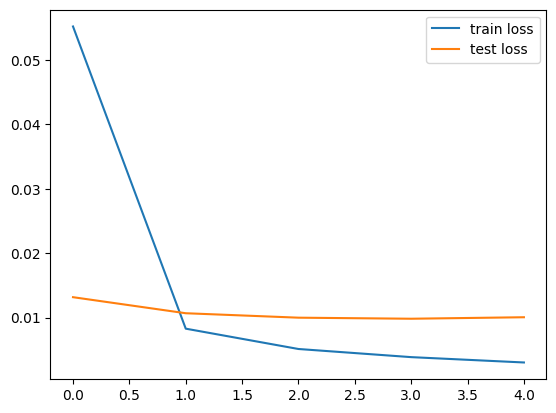

In [29]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='test loss')
plt.legend()

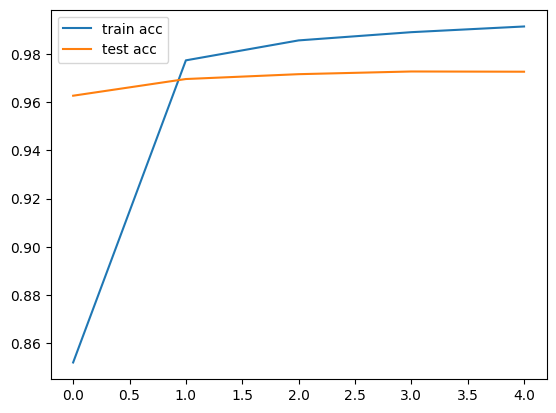

In [30]:
plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='test acc')
plt.legend()

In [32]:
#true model accuracy

train_lengths=[]
for sentence in train_inputs:
    train_lengths.append(len(sentence))
    
test_lengths=[]
for sentence in test_inputs:
    test_lengths.append(len(sentence))

In [33]:
train_probs=model.predict(train_inputs_int) #NxTxK
train_predictions=[]
for probs,length in zip(train_probs,train_lengths):
    #probs is TxK
    probs_=probs[-length:]
    preds=np.argmax(probs_,axis=1)
    train_predictions.append(preds)

#flatten
flat_train_predictions=flatten(train_predictions)
flat_train_targets=flatten(train_targets_int_unpadded)

1255/1255 [==============================] - 66s 49ms/step


In [37]:
test_probs=model.predict(test_inputs_int) #NxTxK
test_predictions=[]
for probs,length in zip(test_probs,test_lengths):
    #probs is TxK
    probs_=probs[-length:]
    preds=np.argmax(probs_,axis=1)
    test_predictions.append(preds)

#flatten
flat_test_predictions=flatten(test_predictions)
flat_test_targets=flatten(test_targets_int_unpadded)

538/538 [==============================] - 26s 48ms/step


In [38]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc: ",accuracy_score(flat_train_targets,flat_train_predictions))
print("test acc: ",accuracy_score(flat_test_targets,flat_test_predictions))

print("Train f1: ",f1_score(flat_train_targets,flat_train_predictions,average='macro'))
print("test f1: ",f1_score(flat_test_targets,flat_test_predictions,average='macro'))

Train acc:  0.9938532935199983
test acc:  0.9727065806733085
Train f1:  0.9861123692566025
test f1:  0.9390879519079931


In [42]:
#baseline model: word to tag map
from collections import Counter

def most_common(lst):
    data=Counter(lst)
    return data.most_common(1)[0][0]

In [43]:
token2tags={k:[]for k,v in word2idx.items()}

#remove UNK token
del token2tags['UNK']

for tokens,tags in zip(train_inputs,train_outputs):
    for token,tag in zip(tokens,tags):
        if should_capitalize:
            token=token.lower()
        if token in token2tags:
            token2tags[token].append(tag)
token2tag={k:most_common(v) for k,v in token2tags.items()}

In [44]:
#compute accuracy

train_predictions=[]
for sentence in train_inputs:
    predictions=[]
    for token in sentence:
        if should_capitalize:
            token=token.lower()
        predicted_tag=token2tag[token]
        predictions.append(predicted_tag)
    train_predictions.append(predictions)
flat_train_predictions=flatten(train_predictions)
flat_train_targets=flatten(train_outputs)

In [45]:
test_predictions=[]
for sentence in test_inputs:
    predictions=[]
    for token in sentence:
        predicted_tag=token2tag.get(token,'INCORRECT')
        predictions.append(predicted_tag)
    test_predictions.append(predictions)
flat_test_predictions=flatten(test_predictions)
flat_test_targets=flatten(test_outputs)

In [46]:
print("Train acc: ",accuracy_score(flat_train_targets,flat_train_predictions))
print("test acc: ",accuracy_score(flat_test_targets,flat_test_predictions))

print("Train f1: ",f1_score(flat_train_targets,flat_train_predictions,average='macro'))
print("test f1: ",f1_score(flat_test_targets,flat_test_predictions,average='macro'))

Train acc:  0.9572855573313255
test acc:  0.92841540876983
Train f1:  0.9380106140162034
test f1:  0.8276115841790587
